# 2A.data - Classification, régression, anomalies - correction

Le jeu de données [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) contient 5000 vins décrits par leurs caractéristiques chimiques et évalués par un expert. Peut-on s'approcher de l'expert à l'aide d'un modèle de machine learning.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Les données

On peut les récupérer sur [github...data_2a](https://github.com/sdpython/ensae_teaching_cs/tree/master/src/ensae_teaching_cs/data/data_1a).

In [1]:
from pandas import read_csv
df_white = read_csv("../Data/winequality-white.csv", sep=';')
df_white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [2]:
df_white.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [3]:
df_white["color"] = "white"
df_white = df_white[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'color', 'quality']]

In [4]:
df_red = read_csv("../Data/winequality-red.csv", sep=';')
df_red["color"] = "red"
df_red = df_red[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'color', 'quality']]

In [5]:
import pandas as pd
df = pd.concat((df_white, df_red)).sample(frac=1).copy()
df.to_csv("../Data/winequality-full.csv", index=False)

In [6]:
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color,quality
2272,6.2,0.25,0.28,8.50,0.035,28.0,108.0,0.99486,3.40,0.42,10.4,white,6
3024,7.0,0.13,0.37,12.85,0.042,36.0,105.0,0.99581,3.05,0.55,10.7,white,6
2962,6.9,0.38,0.38,13.10,0.112,14.0,94.0,0.99792,3.02,0.48,9.2,white,5
3812,7.9,0.21,0.39,2.00,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white,5
1267,8.0,0.22,0.42,14.60,0.044,45.0,163.0,1.00030,3.21,0.69,8.6,white,7
3621,7.1,0.27,0.24,12.60,0.044,48.0,118.0,0.99726,3.04,0.56,10.0,white,7
1569,6.7,0.30,0.74,5.00,0.038,35.0,157.0,0.99450,3.21,0.46,9.9,white,5
4192,6.7,0.20,0.24,6.50,0.044,28.0,100.0,0.99348,3.12,0.33,10.2,white,6
255,8.0,0.57,0.23,3.20,0.073,17.0,119.0,0.99675,3.26,0.57,9.3,red,5
818,6.2,0.30,0.17,2.80,0.040,24.0,125.0,0.99390,3.01,0.46,9.0,white,5


In [7]:
df = read_csv("../Data/winequality-full.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color,quality
0,6.2,0.25,0.28,8.50,0.035,28.0,108.0,0.99486,3.40,0.42,10.4,white,6
1,7.0,0.13,0.37,12.85,0.042,36.0,105.0,0.99581,3.05,0.55,10.7,white,6
2,6.9,0.38,0.38,13.10,0.112,14.0,94.0,0.99792,3.02,0.48,9.2,white,5
3,7.9,0.21,0.39,2.00,0.057,21.0,138.0,0.99176,3.05,0.52,10.9,white,5
4,8.0,0.22,0.42,14.60,0.044,45.0,163.0,1.00030,3.21,0.69,8.6,white,7


In [8]:
ax = df['quality'].hist(bins=16)
ax.set_title("Distribution des notes");

Il y a peu de très mauvais ou très bons vins. On découpe en apprentissage / test ce qui va nécessairement rendre leur prédiction complexe : un modèle reproduit en quelque sorte ce qu'il voit.

In [9]:
from sklearn.model_selection import train_test_split
X = df.drop("quality", axis=1)
y = df["quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
X_train.shape, X_test.shape

((3248, 12), (3249, 12))

In [10]:
from pandas import DataFrame

def distribution(y_train, y_test):
    df_train = DataFrame(dict(color=y_train))
    df_test = DataFrame(dict(color=y_test))
    df_train['ctrain'] = 1
    df_test['ctest'] = 1
    h_train = df_train.groupby('color').count()
    h_test  = df_test.groupby('color').count()
    merge = h_train.join(h_test, how='outer')
    merge["ratio"] = merge.ctest / merge.ctrain
    return merge
    
distribution(y_train, y_test)

,ctrain,ctest,ratio
color,,,
3,14,16,1.142857
4,110,106,0.963636
5,1037,1101,1.061716
6,1435,1401,0.976307
7,544,535,0.983456
8,104,89,0.855769
9,4,1,0.250000


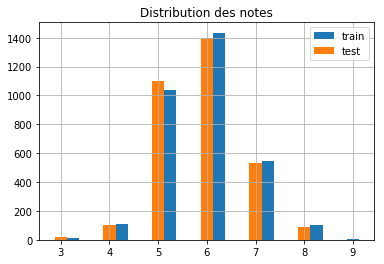

In [11]:
ax = y_train.hist(bins=24, label="train", align="right")
y_test.hist(bins=24, label="test", ax=ax, align="left")
ax.set_title("Distribution des notes")
ax.legend();

Avec un peu de chance, les notes extrêmes sont présentes dans les bases d'apprentissages et de tests mais une note seule a peu d'influence sur un modèle. Pour s'assurer une meilleur répartition train / test, on peut s'assurer que chaque note est bien répartie de chaque côté. On se sert du paramètre [stratify](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

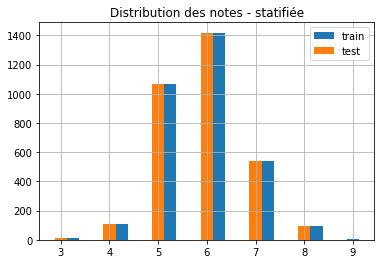

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5)
X_train.shape, X_test.shape
ax = y_train.hist(bins=24, label="train", align="right")
y_test.hist(bins=24, label="test", ax=ax, align="left")
ax.set_title("Distribution des notes - statifiée")
ax.legend();

In [13]:
distribution(y_train, y_test)

,ctrain,ctest,ratio
color,,,
3,15,15,1.000000
4,108,108,1.000000
5,1069,1069,1.000000
6,1418,1418,1.000000
7,539,540,1.001855
8,96,97,1.010417
9,3,2,0.666667


La répartition des notes selon apprentissage / test est plus uniforme.

## Premier modèle

In [14]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
try:
    logreg.fit(X_train, y_train)
except Exception as e:
    print(e)

could not convert string to float: 'white'


C:\Users\m_pic\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color
6203,7.2,0.21,0.33,3.0,0.036,35.0,132.0,0.99280,3.25,0.40,11.0,white
4840,7.2,0.20,0.31,10.0,0.054,49.0,165.0,0.99700,3.40,0.42,9.9,white
5054,6.7,0.16,0.64,2.1,0.059,24.0,52.0,0.99494,3.34,0.71,11.2,red
2452,10.7,0.35,0.53,2.6,0.070,5.0,16.0,0.99720,3.15,0.65,11.0,red
2789,8.3,0.28,0.27,17.5,0.045,48.0,253.0,1.00014,3.02,0.56,9.1,white


Une colonne n'est pas numérique. On utilise un [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [18]:
from sklearn.preprocessing import OneHotEncoder
one = OneHotEncoder()
one.fit(X_train[['color']])
tr = one.transform(X_test[["color"]])
tr

<3249x2 sparse matrix of type '<class 'numpy.float64'>'
	with 3249 stored elements in Compressed Sparse Row format>

La matrice est [sparse ou creuse](https://fr.wikipedia.org/wiki/Matrice_creuse).

In [19]:
tr.todense()[:5]

matrix([[0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.]])

Ensuite il faut fusionner ces deux colonnes avec les données ou une seule puisqu'elles sont corrélées. Ou alors on écrit un pipeline...

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numeric_features = [c for c in X_train if c != 'color']

pipe = Pipeline([
    ("prep", ColumnTransformer([
        ("color", Pipeline([
            ('one', OneHotEncoder()),
            ('select', ColumnTransformer([('sel1', 'passthrough', [0])]))
        ]), ['color']),
        ("others", "passthrough", numeric_features)
    ])),
])

pipe.fit(X_train)
pipe.transform(X_test)[:2]

array([[0.0000e+00, 7.4000e+00, 1.6000e-01, 3.0000e-01, 1.3700e+01,
        5.6000e-02, 3.3000e+01, 1.6800e+02, 9.9825e-01, 2.9000e+00,
        4.4000e-01, 8.7000e+00],
       [1.0000e+00, 8.8000e+00, 6.1000e-01, 3.0000e-01, 2.8000e+00,
        8.8000e-02, 1.7000e+01, 4.6000e+01, 9.9760e-01, 3.2600e+00,
        5.1000e-01, 9.3000e+00]])

In [21]:
from jyquickhelper import RenderJsDot
from mlinsights.plotting import pipeline2dot
dot = pipeline2dot(pipe, X_train)
RenderJsDot(dot)

Il reste quelques bugs. On ajoute un classifieur.

In [22]:
pipe = Pipeline([
    ("prep", ColumnTransformer([
        ("color", Pipeline([
            ('one', OneHotEncoder()),
            ('select', ColumnTransformer([('sel1', 'passthrough', [0])]))
        ]), ['color']),
        ("others", "passthrough", numeric_features)
    ])),
    ("lr", LogisticRegression(max_iter=1000)),
])

pipe.fit(X_train, y_train)

C:\Users\m_pic\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\m_pic\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('prep',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('color',
                                                  Pipeline(memory=None,
                                                           steps=[('one',
                                                                   OneHotEncoder(categorical_features=None,
                                                                                 categories=None,
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='error',
                                                 

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00       108
           5       0.58      0.64      0.61      1069
           6       0.51      0.72      0.60      1418
           7       0.52      0.06      0.11       540
           8       0.00      0.00      0.00        97
           9       0.00      0.00      0.00         2

    accuracy                           0.54      3249
   macro avg       0.23      0.20      0.19      3249
weighted avg       0.50      0.54      0.48      3249



C:\Users\m_pic\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Pas extraordinaire.

In [24]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
    ("prep", ColumnTransformer([
        ("color", Pipeline([
            ('one', OneHotEncoder()),
            ('select', ColumnTransformer([('sel1', 'passthrough', [0])]))
        ]), ['color']),
        ("others", "passthrough", numeric_features)
    ])),
    ("lr", RandomForestClassifier()),
])

pipe.fit(X_train, y_train)
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00        15
           4       0.39      0.11      0.17       108
           5       0.63      0.71      0.67      1069
           6       0.60      0.67      0.63      1418
           7       0.60      0.43      0.50       540
           8       0.56      0.21      0.30        97
           9       0.00      0.00      0.00         2

    accuracy                           0.61      3249
   macro avg       0.40      0.30      0.33      3249
weighted avg       0.60      0.61      0.59      3249



C:\Users\m_pic\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\m_pic\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Beaucoup mieux.

## Courbe ROC pour chaque classe

In [25]:
from sklearn.metrics import roc_curve, auc

labels = pipe.steps[1][1].classes_
y_score = pipe.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i, cl in enumerate(labels):
    fpr[cl], tpr[cl], _ = roc_curve(y_test == cl, y_score[:, i])
    roc_auc[cl] = auc(fpr[cl], tpr[cl])

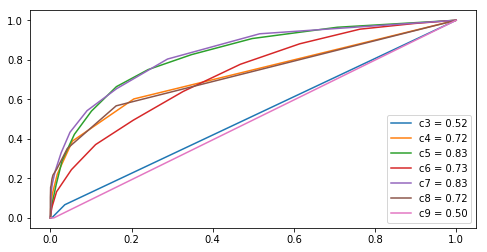

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
for k in roc_auc:
    ax.plot(fpr[k], tpr[k], label="c%d = %1.2f" % (k, roc_auc[k]))
ax.legend();

Ces chiffres peuvent paraître élevés mais ce n'est pas formidable quand même.

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pipe.predict(X_test), labels=labels)

array([[  0,   1,   9,   4,   1,   0,   0],
       [  1,  12,  62,  31,   2,   0,   0],
       [  0,  13, 755, 290,  11,   0,   0],
       [  1,   3, 340, 955, 112,   7,   0],
       [  0,   2,  30, 265, 234,   9,   0],
       [  0,   0,   0,  49,  28,  20,   0],
       [  0,   0,   0,   1,   1,   0,   0]], dtype=int64)

Ce n'est pas très joli...

In [28]:
def confusion_matrix_df(y_test, y_true):
    conf = confusion_matrix(y_test, y_true)
    labels = list(sorted(set(y_test)))
    df = DataFrame(conf, columns=labels)
    df.set_index(labels)
    return df

confusion_matrix_df(y_test, pipe.predict(X_test))

,3,4,5,6,7,8,9
0,0,1,9,4,1,0,0
1,1,12,62,31,2,0,0
2,0,13,755,290,11,0,0
3,1,3,340,955,112,7,0
4,0,2,30,265,234,9,0
5,0,0,0,49,28,20,0
6,0,0,0,1,1,0,0


Mais cela veut dire que pour un score élevé, le taux de bonne classification s'améliore.

In [29]:
import numpy
ind = numpy.max(pipe.predict_proba(X_test), axis=1) >= 0.6
confusion_matrix_df(y_test[ind], pipe.predict(X_test)[ind])

,3,4,5,6,7,8,9
0,0,0,4,2,0,0,0
1,0,7,30,17,0,0,0
2,0,7,578,179,2,0,0
3,0,0,183,701,49,4,0
4,0,0,4,152,178,2,0
5,0,0,0,23,20,16,0
6,0,0,0,1,1,0,0


Les petites classes ont disparu : le modèle n'est pas sûr du tout pour les classes 3, 4, 9. On voit aussi que le modèle se trompe souvent d'une note, il serait sans doute plus judicieux de passer à un modèle de régression plutôt que de classification. Cependant, un modèle de régression ne fournit pas de score de confiance. Sans doute serait-il possible d'en construire avec un modèle de détection d'anomalie...

## Anomalies

Une anomalie est un point aberrant. Cela revient à dire que sa probabilité qu'un tel événement se reproduise est faible. Un modèle assez connu est [EllipticEnvelope](https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html). On suppose que si le modèle détecte une anomalie, un modèle de prédiction aura plus de mal à prédire. On réutilise le pipeline précédent en changeant juste la dernière étape.

In [30]:
from sklearn.covariance import EllipticEnvelope

one = Pipeline([
    ("prep", ColumnTransformer([
        ("color", Pipeline([
            ('one', OneHotEncoder()),
            ('select', ColumnTransformer([('sel1', 'passthrough', [0])]))
        ]), ['color']),
        ("others", "passthrough", numeric_features)
    ])),
    ("lr", EllipticEnvelope()),
])

one.fit(X_train)
ano = one.predict(X_test)
ano

array([1, 1, 1, ..., 1, 1, 1])

In [31]:
from pandas import DataFrame
df = DataFrame(dict(note=y_test, ano=one.decision_function(X_test), 
                    pred=pipe.predict(X_test), 
                    errors=y_test == pipe.predict(X_test),
                    proba_max=numpy.max(pipe.predict_proba(X_test), axis=1),
                ))
df["anoclip"] = df.ano.apply(lambda x: max(x, -200))
df.head()

,note,ano,pred,errors,proba_max,anoclip
2570,7,79.347810,7,True,0.9,79.347810
1886,4,9.702532,5,False,0.7,9.702532
1086,6,86.703512,6,True,0.5,86.703512
4184,5,79.877383,5,True,1.0,79.877383
1977,7,82.923755,6,False,0.8,82.923755


C:\Users\m_pic\Miniconda3\lib\site-packages\seaborn\regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]
C:\Users\m_pic\Miniconda3\lib\site-packages\seaborn\regression.py:282: RuntimeWarning: invalid value encountered in log
  _x = np.c_[_x[:, 0], np.log(_x[:, 1])]
C:\Users\m_pic\Miniconda3\lib\site-packages\numpy\linalg\linalg.py:1974: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


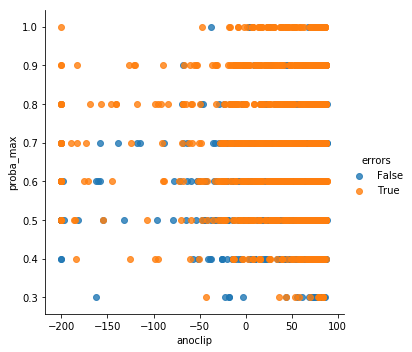

In [32]:
import seaborn
seaborn.lmplot(x="anoclip", y="proba_max", hue="errors",
               truncate=True, height=5, data=df,
               logx=True);

In [33]:
df.corr()

,note,ano,pred,errors,proba_max,anoclip
note,1.000000,0.115242,0.582534,-0.105596,-0.027645,0.187008
ano,0.115242,1.000000,0.087456,0.005892,-0.005886,0.626768
pred,0.582534,0.087456,1.000000,-0.014610,0.007810,0.144389
errors,-0.105596,0.005892,-0.014610,1.000000,0.313920,-0.002544
proba_max,-0.027645,-0.005886,0.007810,0.313920,1.000000,0.013113
anoclip,0.187008,0.626768,0.144389,-0.002544,0.013113,1.000000


Les résultats précédents ne sont pas probants. On peut changer de modèle de détection d'anomalies mais les conclusions restent les mêmes. Le score d'anomalie n'est pas relié au score de prédiction.

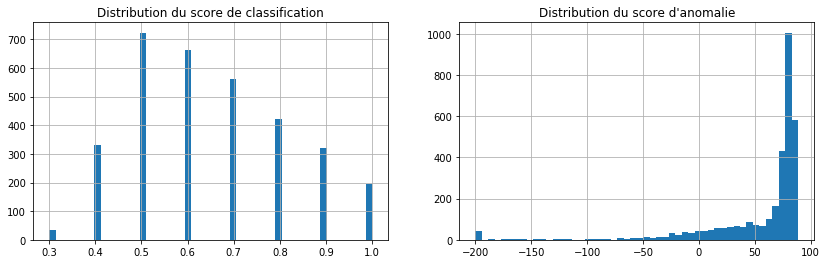

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
df.proba_max.hist(ax=ax[0], bins=50)
df.anoclip.hist(ax=ax[1], bins=50)
ax[0].set_title("Distribution du score de classification")
ax[1].set_title("Distribution du score d'anomalie");

C'est joli mais ils n'ont rien à voir. Et c'était prévisible car le modèle de prédiction qu'on utilise est tout-à-fait capable de prédire ce qu'est une anomalie. 

In [35]:

pipe_ano = Pipeline([
    ("prep", ColumnTransformer([
        ("color", Pipeline([
            ('one', OneHotEncoder()),
            ('select', ColumnTransformer([('sel1', 'passthrough', [0])]))
        ]), ['color']),
        ("others", "passthrough", numeric_features)
    ])),
    ("lr", RandomForestClassifier()),
])

pipe_ano.fit(X_train, one.predict(X_train))
confusion_matrix_df(one.predict(X_test), pipe_ano.predict(X_test))

C:\Users\m_pic\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,-1,1
0,301,24
1,33,2891


Le modèle d'anomalie n'apporte donc aucune information nouvelle. Cela signifie que le modèle prédictif initial n'améliorerait pas sa prédiction en utilisant le score d'anomalie. Il n'y a donc aucune chance que les erreurs ou les score de prédiction soient corrélés au score d'anomalie d'une manière ou d'une autre.

## Score de confiance pour une régression

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

pipe_reg = Pipeline([
    ("prep", ColumnTransformer([
        ("color", Pipeline([
            ('one', OneHotEncoder()),
            ('select', ColumnTransformer([('sel1', 'passthrough', [0])]))
        ]), ['color']),
        ("others", "passthrough", numeric_features)
    ])),
    ("lr", RandomForestRegressor()),
])

pipe_reg.fit(X_train, y_train)
r2_score(y_test, pipe_reg.predict(X_test))

C:\Users\m_pic\AppData\Roaming\Python\Python37\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.42065394341719975

Pas super. Mais...

In [37]:
error = y_test - pipe_reg.predict(X_test)
score = numpy.max(pipe.predict_proba(X_test), axis=1)

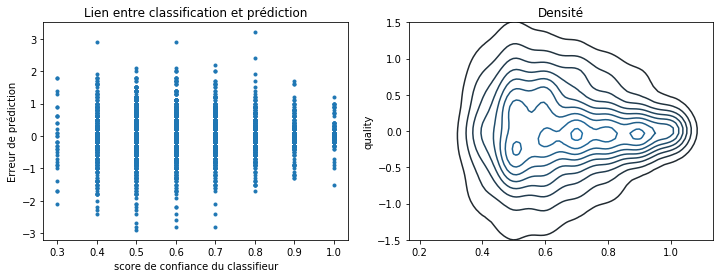

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
seaborn.kdeplot(score, error, ax=ax[1])
ax[1].set_ylim([-1.5, 1.5])
ax[1].set_title("Densité")
ax[0].plot(score, error, ".")
ax[0].set_xlabel("score de confiance du classifieur")
ax[0].set_ylabel("Erreur de prédiction")
ax[0].set_title("Lien entre classification et prédiction");

Comme prévu le modèle ne se trompe pas plus dans un sens que dans l'autre.

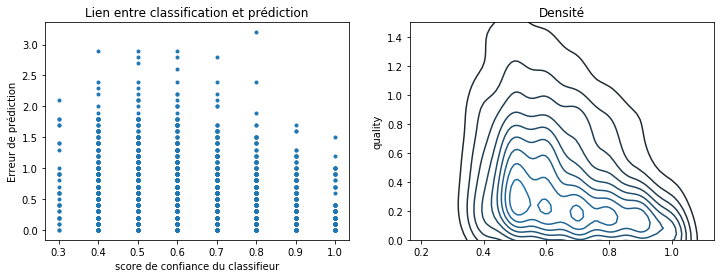

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
seaborn.kdeplot(score, error.abs(), ax=ax[1])
ax[1].set_ylim([0, 1.5])
ax[1].set_title("Densité")
ax[0].plot(score, error.abs(), ".")
ax[0].set_xlabel("score de confiance du classifieur")
ax[0].set_ylabel("Erreur de prédiction")
ax[0].set_title("Lien entre classification et prédiction");

On vient de construire un indicateur de confiance pour un modèle de régression. On voit aussi que l'erreur de prédiction est concentrée autour de 0.5 lorsque le score est faible. C'est normal dans la mesure où la probabilité est faible lorsque le classifieur n'est pas sûr, c'est-à-dire que l'observation à prédire est proche de la frontière entre deux classes. Ces classes sont centrées autour des notes entières, les frontières sont au milieu, soit approximativement 3.5, 4.5, ... Ce n'est pas une preuve mais seulement la vérifie que l'intervalle de confiance qu'on vient de fabriquer n'est pas complètement aberrant.